# Multilayer thin film coverage model: fitting and simulation

### Sumner B. Harris

###10/08/24

This notebook provides the MultiLayerCoverageModel class which contructs a system of ODEs that can be used to simulate or fit experimental laser reflectivity curves. The class takes in a list of layer_contrasts (determined elsewhere by solve the Fresnel equations for your layer stack)


In [1]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import minimize
import matplotlib.pyplot as plt

class MultiLayerCoverageModel:
    """
    A class to model a multilayer thin film coverage system using ordinary differential equations (ODEs)
    to simulate and fit experimental data related to layer coverage and contrast.

    Attributes:
    -----------
    num_layers : int
        Number of layers in the system.
    layer_contrasts : list of floats
        Contrast values associated with each layer.
    """
    def __init__(self, num_layers, layer_contrasts):
        self.num_layers = num_layers
        self.layer_contrasts = layer_contrasts
        
    def coverage_model_system(self, y, t, *params):
        """
        Defines the system of ODEs that models the multilayer coverage process.

        Parameters:
        -----------
        y : list of floats
            Current state of each layer (coverage values).
        t : float
            Time variable.
        params : list of floats
            Parameters controlling the ODE system (e.g., adsorption and desorption rates).

        Returns:
        --------
        dydt : numpy array
            Derivatives of the state variables, describing the rate of change in each layer.
        """
        dydt = np.zeros(self.num_layers)
        # Loop through layers to define the system of ODEs
        for i in range(self.num_layers):
            if i == 0:  # First layer
                dydt[i] = params[2 * i] * (1 - y[i]) + params[2 * i + 1] * (1 - y[i]) * y[i]
            else:
                dydt[i] = params[2 * i] * (y[i-1] - y[i]) + params[2 * i + 1] * (y[i-1] - y[i]) * y[i]
        return dydt
    
    def convert_to_contrast(self,dydt):
        """
        Converts the ODE results into contrast values, taking into account the contrast contribution of each layer.

        Parameters:
        -----------
        dydt : numpy array
            ODE solution representing the rate of change for each layer over time.

        Returns:
        --------
        contrast : numpy array
            Computed contrast based on layer coverage changes.
        """
        contrast = np.zeros(dydt.shape[0])
        for i in range(dydt.shape[1]):
            if i == 0: #first layer
                contrast += dydt[:, i] * self.layer_contrasts[i]
            else:
                contrast += dydt[:,i]*(self.layer_contrasts[i] - self.layer_contrasts[i-1])
        return contrast
    
    # Define the objective function for optimization
    def objective_function(self, params, t, data):
        """
        Objective function used for optimization, calculating the difference 
        between model output and experimental data.

        Parameters:
        -----------
        params : array-like
            Current parameters being tested during optimization.
        t : array-like
            Time points for the ODE integration.
        data : array-like
            Experimental contrast data for comparison with the model output.

        Returns:
        --------
        error : float
            Sum of squared differences between model output and experimental data.
        """
        num_params = len(params)//2
        y0 = [0 for i in range(self.num_layers)]
        result = odeint(self.coverage_model_system, y0, t, args=tuple(params))
        model_output = self.convert_to_contrast(result)  # Assuming you want to fit to the second variable

        return np.sum((model_output - data) ** 2)  # Sum of squared differences
    
    def fit(self, time, contrast, initial_params, parameter_bounds):
        """
        Fits the model to the experimental contrast data by optimizing the parameters.

        Parameters:
        -----------
        time : array-like
            Time points for the ODE integration.
        contrast : array-like
            Experimental contrast data to fit the model to.
        initial_params : list of floats
            Initial guesses for the parameters to be optimized.
        parameter_bounds : list of tuples
            Bounds for the parameters used in optimization.

        Returns:
        --------
        result.x : array-like
            Optimized parameters that minimize the objective function.
        """
        result = minimize(self.objective_function, initial_params, args=(time, contrast),\
                          method='L-BFGS-B',bounds=parameter_bounds)
        
        self.optimized_params = result.x
        
        return result.x
    
    def optimized_curve(self,t):
        """
        Simulates the system using the optimized parameters and returns the coverage 
        and contrast over time.

        Parameters:
        -----------
        t : array-like
            Time points for the ODE integration.

        Returns:
        --------
        fitted_contrast : array-like
            Simulated contrast using the optimized parameters.
        optimal_result : array-like
            Simulated coverage for each layer over time.
        """
        num_params = len(self.optimized_params)//2
        y0 = [0 for i in range(self.num_layers)]
        
        optimal_result = odeint(self.coverage_model_system, y0, t, args=(tuple(self.optimized_params)))
        fitted_contrast = self.convert_to_contrast(optimal_result)
        
        return fitted_contrast, optimal_result
    
    def simulate_curve(self,t,parameters):
        """
        Simulates the system using a given set of parameters.

        Parameters:
        -----------
        t : array-like
            Time points for the ODE integration.
        parameters : array-like
            Parameters to be used for the simulation.

        Returns:
        --------
        coverage : array-like
            Simulated coverage for each layer over time.
        contrast : array-like
            Simulated contrast based on the coverage and layer contrasts.
        """
        y0 = [0 for i in range(self.num_layers)]
        coverage = odeint(self.coverage_model_system, y0, t, args=(tuple(parameters)))
        contrast = self.convert_to_contrast(coverage)
        
        return coverage, contrast

# Fit arbitray layer ODE to experimental data

Layer 1: kn = 2.662e-03, kgr = 4.900e-02
Layer 2: kn = 2.331e-03, kgr = 8.948e-02
Layer 3: kn = 1.000e-06, kgr = 2.232e-02


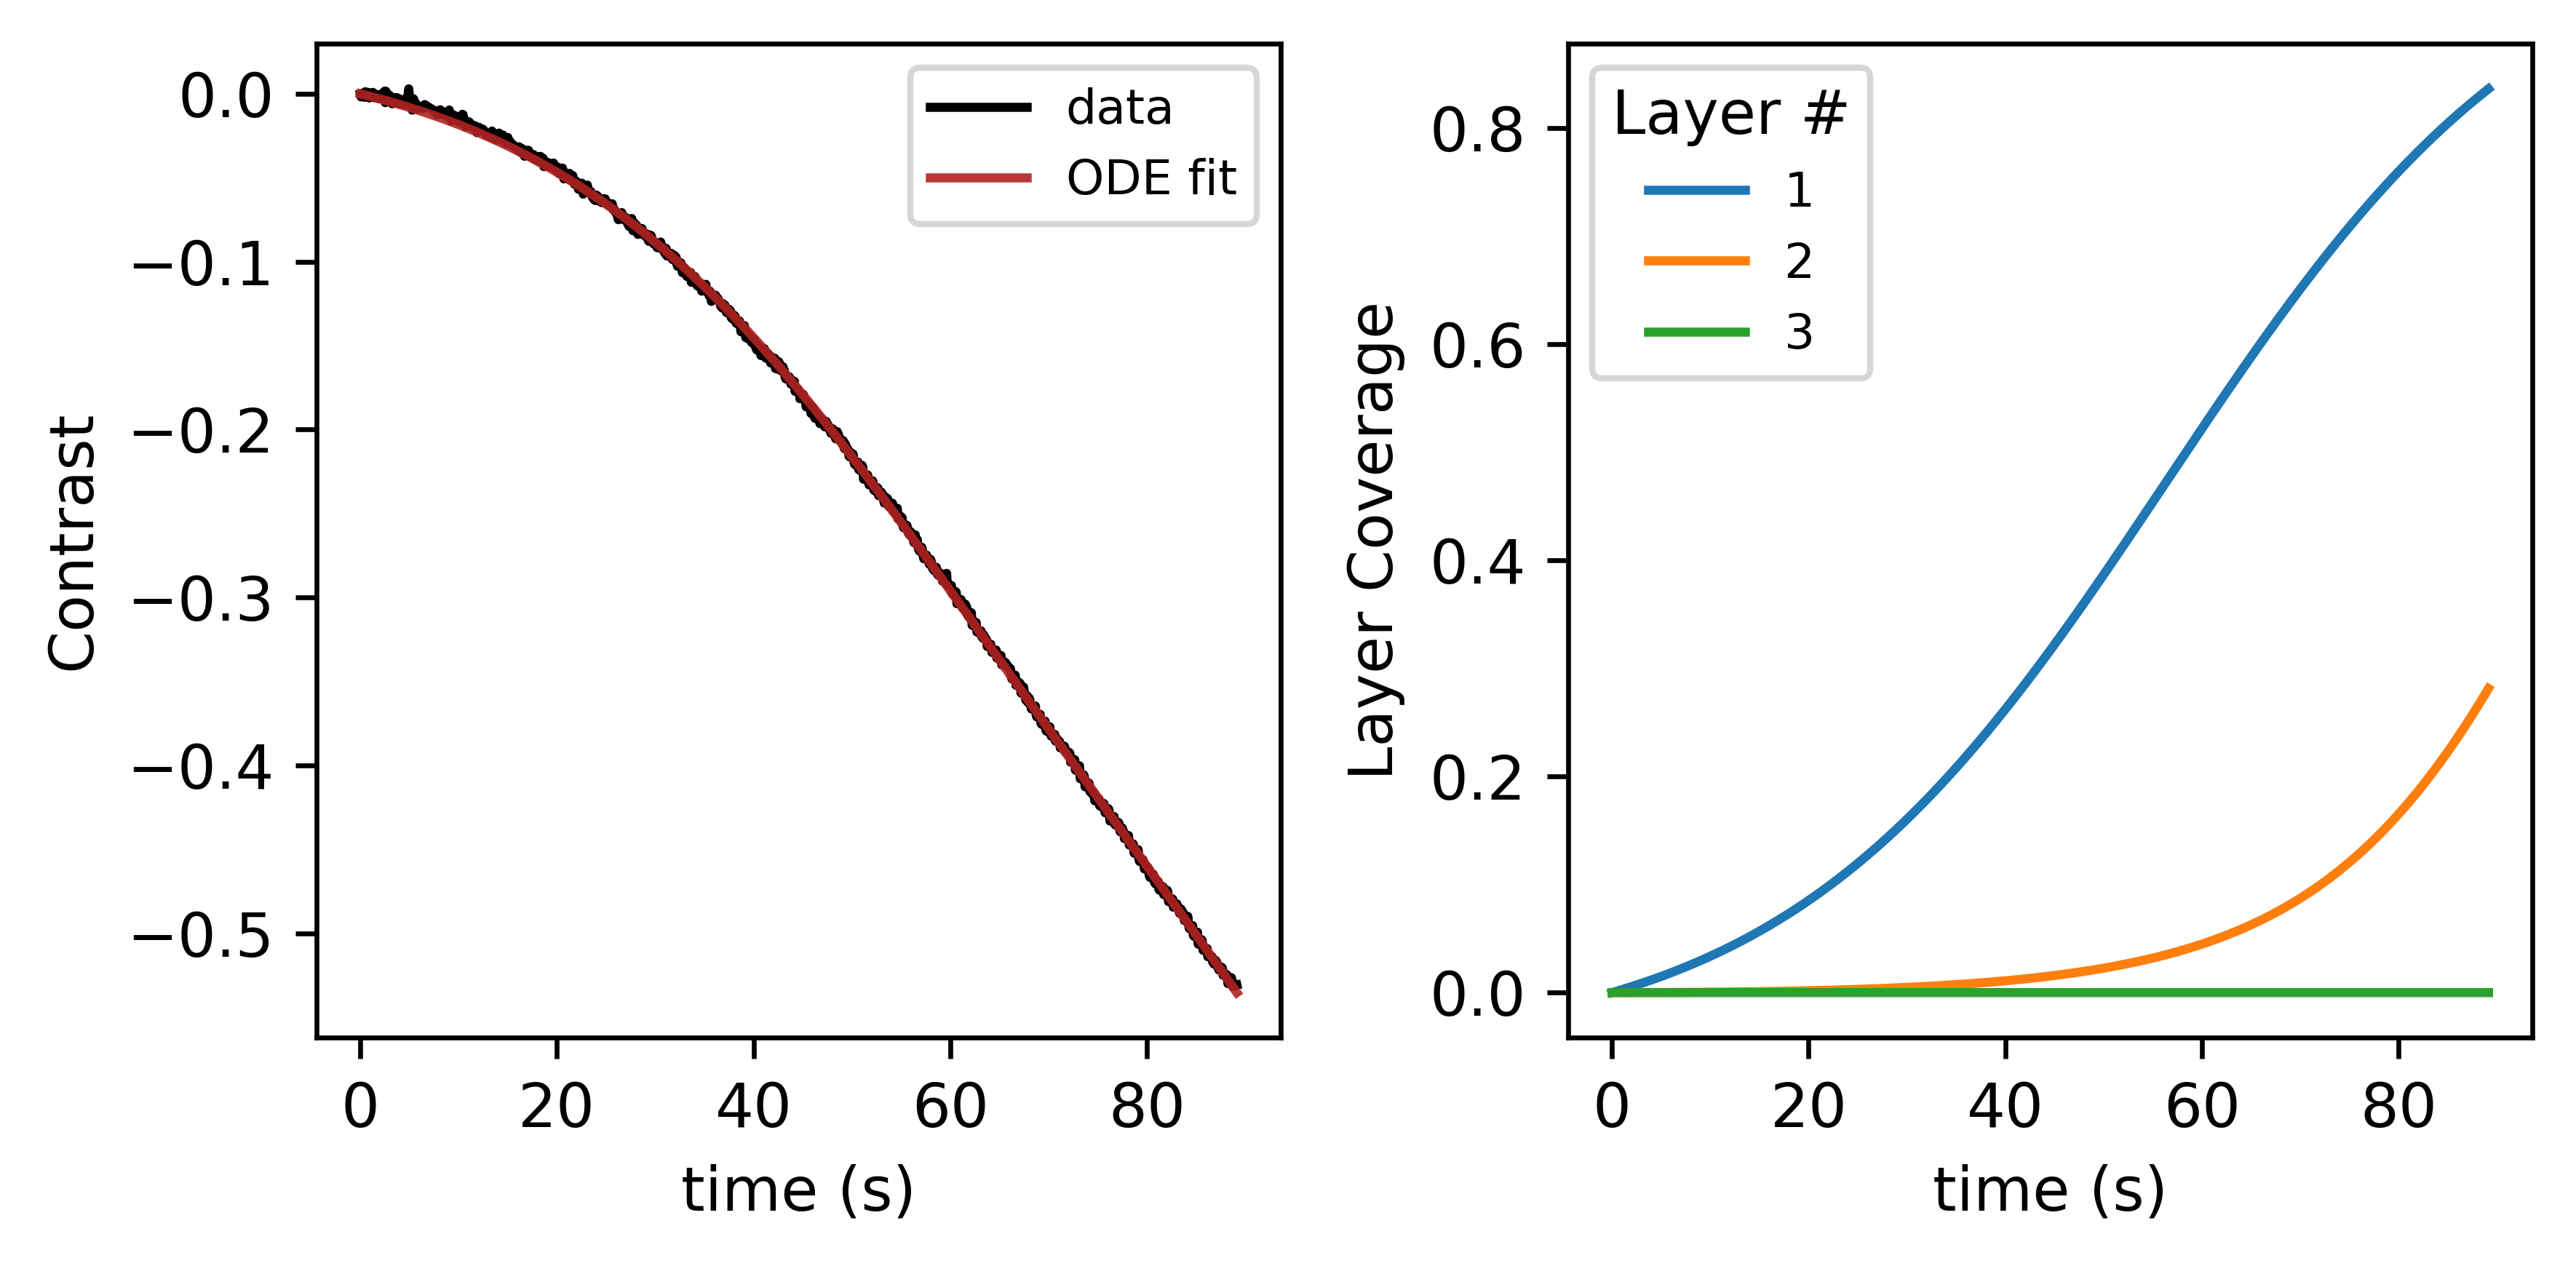

In [2]:
# Number of layers and corresponding contrast values
num_layers = 3 # number of layers to consider in ODE model
layer_contrasts = np.array([-0.5421, -0.8343, -0.9456,-0.9314,-0.8330,-0.6805,-0.4948,-0.2904,-0.0772,0.1381]) # from fresnel eq.
initial_params = []
bounds = []
#set generic initial gues and bounds for kns, kgrs
for i in range(num_layers):
    initial_params.append(0.002)
    initial_params.append(0.02)
    bounds.append((1e-6,1))
    bounds.append((1e-6,1))

# Create an instance of the model
model = MultiLayerCoverageModel(num_layers,
                                layer_contrasts,
                               )

# Example data (replace this with your actual data)
data = np.load('example_data.npz')

t0, C = data['time'],data['contrast']
t = t0[(t0>=0)] #take only the data after the laser starts firing at t=0
C = C[(t0>=0)] #take only the data after the laser starts firing at t=0

optim_params = model.fit(t,C,initial_params,bounds)
layer_names = [i+1 for i in range(optim_params.shape[0]//2)]
for i in range(0,optim_params.shape[0],2):
    print('Layer {}: kn = {:.3e}, kgr = {:.3e}'.format(layer_names[i//2],optim_params[i],optim_params[i+1]))

fitted_contrast, fitted_coverage = model.optimized_curve(t)


#Plot Results
fig, ax = plt.subplots(1,2,figsize=(6,3),dpi=600) # initialize figure, axes


ax[0].plot(t,C,label='data',c='k') # plot data
ax[0].plot(t,fitted_contrast,label='ODE fit',c='firebrick',alpha=0.9) # plot ODE fit
ax[0].set_ylabel('Contrast')
ax[0].set_xlabel('time (s)')
ax[0].legend(loc='upper right',fontsize=8)

#plot individual layer coverages vs time
for i in range(fitted_coverage.shape[1]):
    ax[1].plot(t,fitted_coverage[:,i],label=i+1)
    
ax[1].set_ylabel('Layer Coverage')
ax[1].set_xlabel('time (s)')
ax[1].legend(title='Layer #',loc='upper left',fontsize=8,title_fontsize=10)
    
fig.tight_layout()

# Simulate arbitray layer ODE contrast

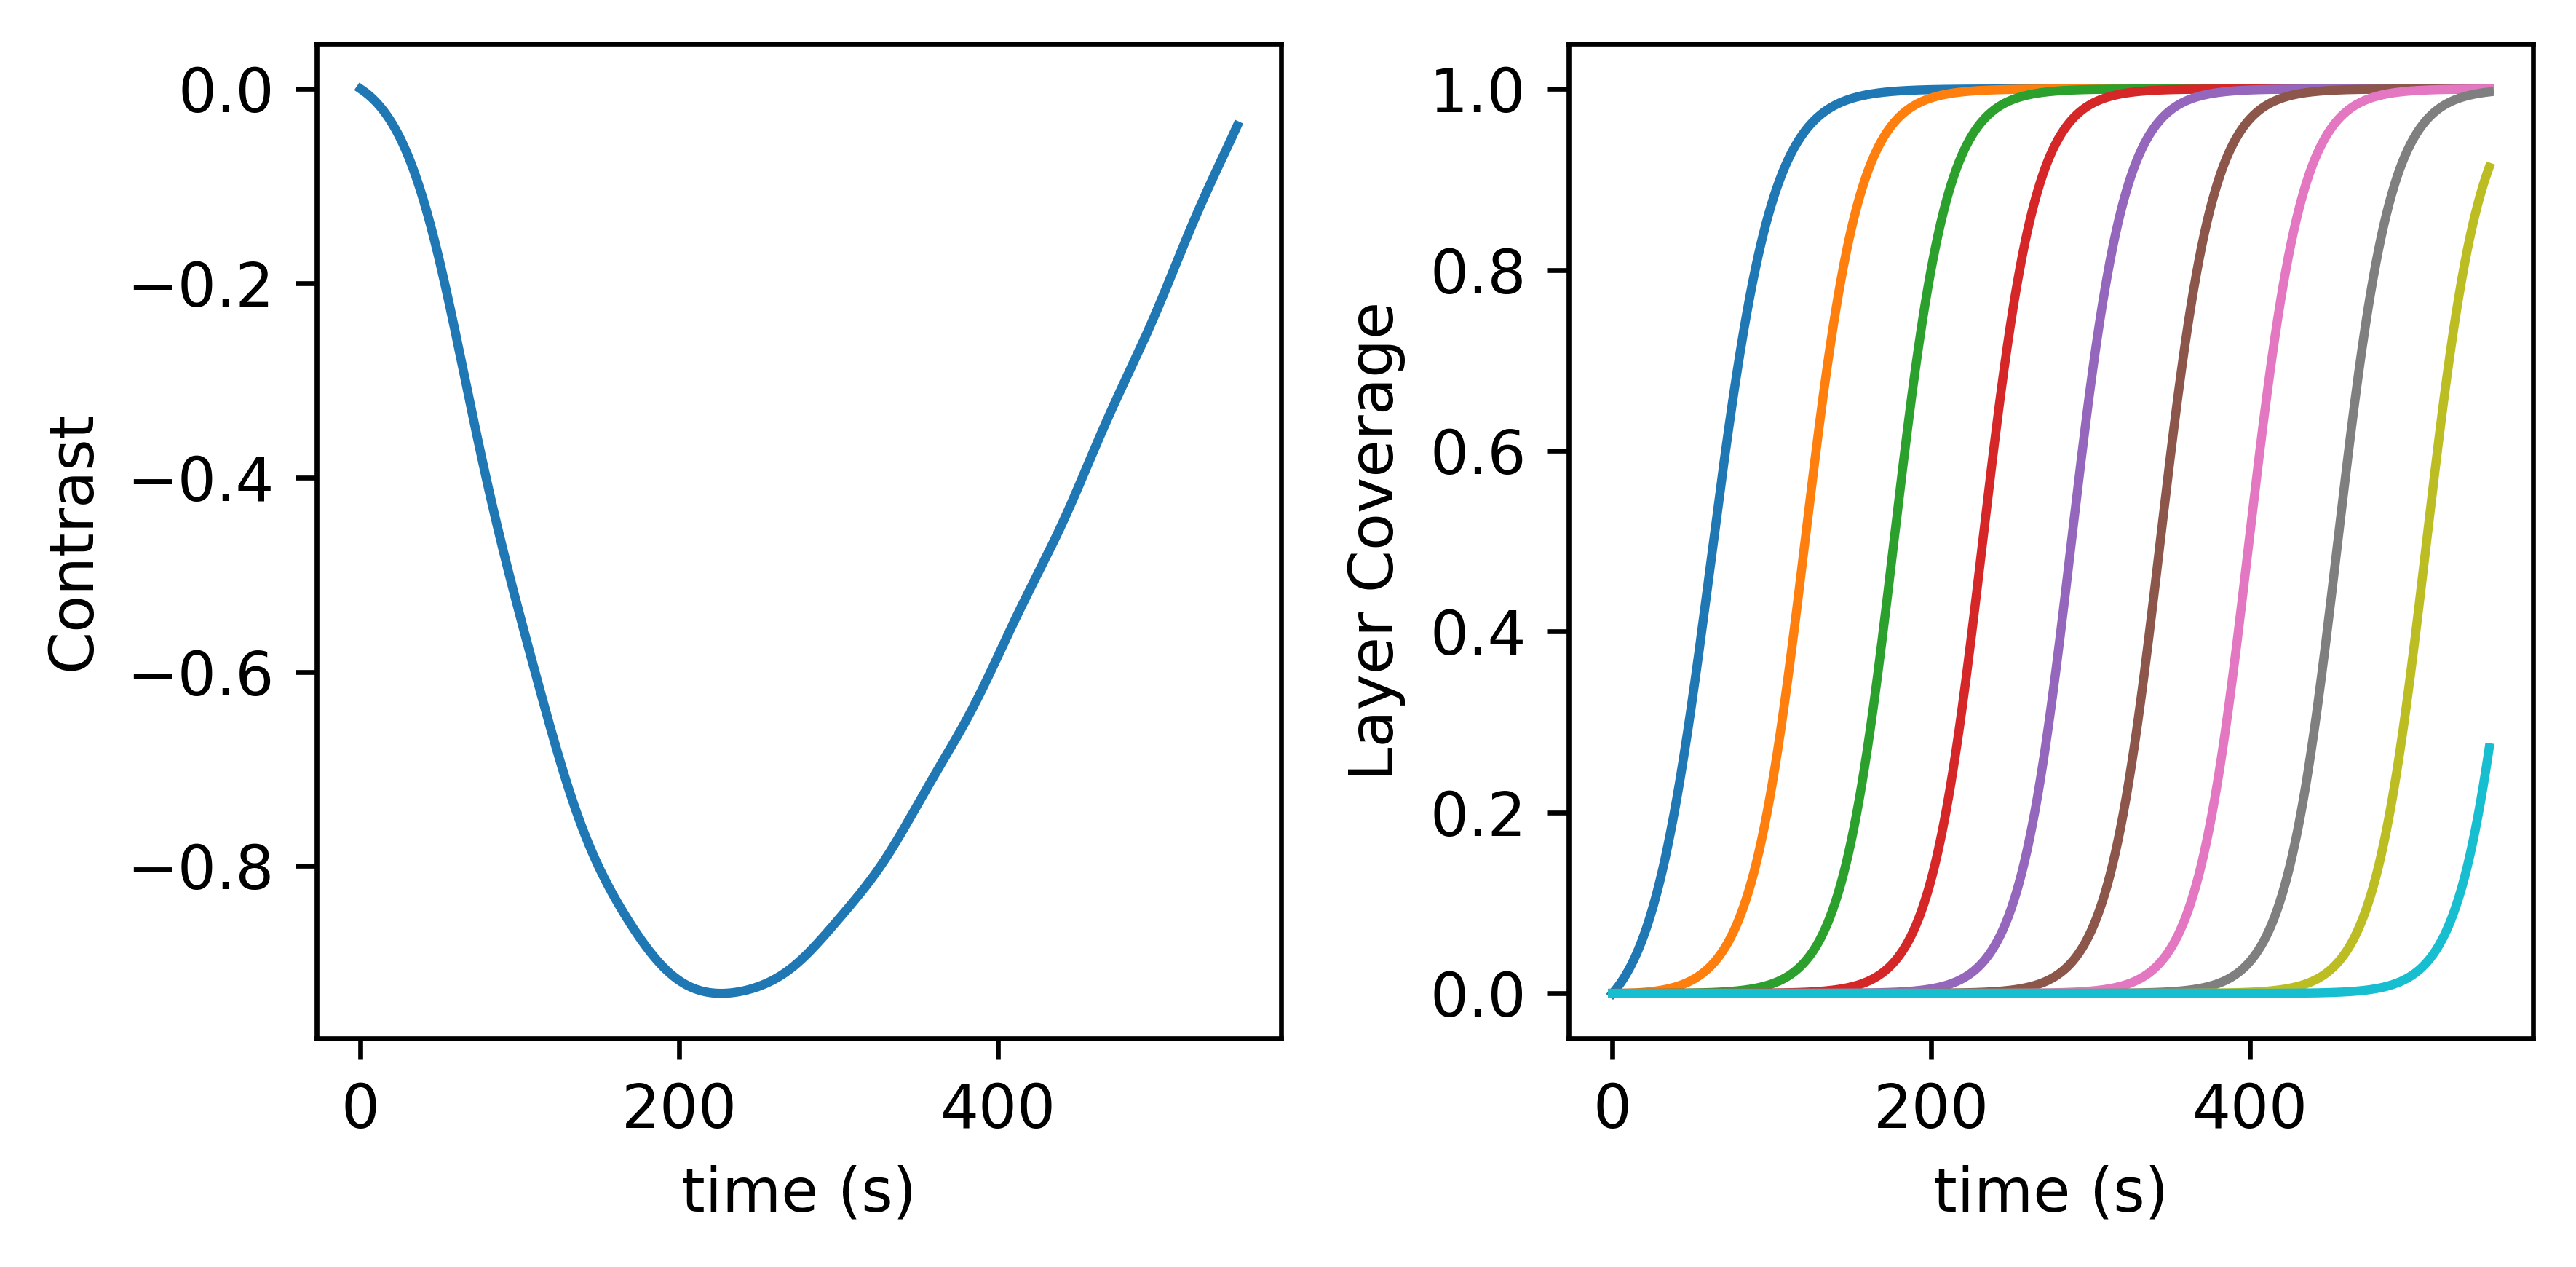

In [3]:
# Number of layers and corresponding contrast values
num_layers = 10
layer_contrasts = np.array([-0.5421, -0.8343, -0.9456,-0.9314,-0.8330,-0.6805,-0.4948,-0.2904,-0.0772,0.1381])
params = []


#set nucleation and growth rates
for i in range(num_layers):
    if i == 0: #first layer
        params.append(0.002)
        params.append(0.05)
    else:
        params.append(0.002*1.1) #nucleate 10% faster on subsequent layers
        params.append(0.05*1.20) #grow 20% faster on subsequent layers
        


# Create an instance of the model
model = MultiLayerCoverageModel(num_layers,
                                layer_contrasts
                               )

t_sim = np.linspace(0,550,1000)
coverage, contrast = model.simulate_curve(t_sim,params)

fig, ax = plt.subplots(1,2,figsize=(6,3),dpi=600)
ax[0].plot(t_sim,contrast,)
ax[0].set_ylabel('Contrast')
ax[0].set_xlabel('time (s)')

for i in range(coverage.shape[1]):
    ax[1].plot(t_sim, coverage[:,i],label=i+1)
    
ax[1].set_ylabel('Layer Coverage')
ax[1].set_xlabel('time (s)')

plt.tight_layout()
plt.show()